<a href="https://colab.research.google.com/github/s-choung/Matlantis_benchmarking/blob/main/m3gnet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install m3gnet


In [5]:
import warnings

from m3gnet.models import Relaxer
from pymatgen.core import Lattice, Structure

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

# Init a Mo structure with stretched lattice (DFT lattice constant ~ 3.168)
mo = Structure(Lattice.cubic(3.3), ["Mo", "Mo"], [[0., 0., 0.], [0.5, 0.5, 0.5]])

relaxer = Relaxer()  # This loads the default pre-trained model

relax_results = relaxer.relax(mo, verbose=True)

final_structure = relax_results['final_structure']
final_energy_per_atom = float(relax_results['trajectory'].energies[-1] / len(mo))

print(f"Relaxed lattice parameter is {final_structure.lattice.abc[0]:.3f} Å")
print(f"Final energy is {final_energy_per_atom:.3f} eV/atom")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:39:36      -21.330704*      10.2491


FIRE:    1 16:39:42      -20.743158*      20.4843
FIRE:    2 16:39:42      -21.694870*       2.4213
FIRE:    3 16:39:42      -21.208536*      11.5265
FIRE:    4 16:39:42      -21.353798*       9.9677
FIRE:    5 16:39:42      -21.562599*       6.5603
FIRE:    6 16:39:42      -21.702246*       2.0209
FIRE:    7 16:39:43      -21.696190*       2.3511
FIRE:    8 16:39:43      -21.697777*       2.2639
FIRE:    9 16:39:43      -21.700720*       2.0934
FIRE:   10 16:39:43      -21.704584*       1.8471
FIRE:   11 16:39:43      -21.708820*       1.5354
FIRE:   12 16:39:43      -21.712812*       1.1708
FIRE:   13 16:39:43      -21.716003*       0.7668
FIRE:   14 16:39:43      -21.717945*       0.3373
FIRE:   15 16:39:43      -21.718319*       0.1499
FIRE:   16 16:39:43      -21.718321*       0.1483
FIRE:   17 16:39:43      -21.718327*       0.1451
FIRE:   18 16:39:43      -21.718332*       0.1402
FIRE:   19 16:39:43      -21.718342*       0.1339
FIRE:   20 16:39:43      -21.718346*       0.1262


In [3]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy

import ase.io
import ase.calculators.singlepoint

In [4]:
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
import numpy as np

mo = bulk("Ru", "fcc", a=3.8, cubic=True)

relaxer = Relaxer()  # This loads the default pre-trained model

relax_results = relaxer.relax(mo, verbose=True)

final_structure = relax_results['final_structure']
final_energy_per_atom = float(relax_results['trajectory'].energies[-1] / len(mo))

print(f"Relaxed lattice parameter is {final_structure.lattice.abc[0]:.3f} Å")
print(f"Final energy is {final_energy_per_atom:.3f} eV/atom")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:39:21      -37.205311*       2.6080
FIRE:    1 16:39:21      -37.038918*       9.0312
FIRE:    2 16:39:21      -37.216648*       0.8654
FIRE:    3 16:39:21      -37.217388*       0.6049
FIRE:    4 16:39:21      -37.218060*       0.1670
FIRE:    5 16:39:21      -37.217911*       0.3144
FIRE:    6 16:39:21      -37.217937*       0.2914
FIRE:    7 16:39:21      -37.217979*       0.2471
FIRE:    8 16:39:21      -37.218033*       0.1847
FIRE:    9 16:39:21      -37.218082*       0.1086
FIRE:   10 16:39:21      -37.218105*       0.0243
Relaxed lattice parameter is 3.820 Å
Final energy is -9.305 eV/atom


In [6]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter


def aseify_reactions(reactions):
    for i, reaction in enumerate(reactions):
        for j, _ in enumerate(reactions[i]['reactionSystems']):
            with io.StringIO() as tmp_file:
                system = reactions[i]['reactionSystems'][j].pop('systems')
                tmp_file.write(system.pop('InputFile'))
                tmp_file.seek(0)
                atoms = ase.io.read(tmp_file, format='json')
            calculator = ase.calculators.singlepoint.SinglePointCalculator(
                atoms,
                energy=system.pop('energy')
            )
            atoms.set_calculator(calculator)
            #print(atoms.get_potential_energy())
            reactions[i]['reactionSystems'][j]['atoms'] = atoms
        # flatten list further into {name: atoms, ...} dictionary
        reactions[i]['reactionSystems'] = {x['name']: x['atoms']
                                          for x in reactions[i]['reactionSystems']}
                                        

In [7]:
import os

benchmark="ComerUnraveling2022"
path_json = os.path.join(os.getcwd(),benchmark+".json")
with open(path_json, 'r') as f:
  data = json.load(f)
dat=data['raw_reactions']
dat = copy.deepcopy(dat)
aseify_reactions(dat)

real_E=[round(dat[i]['reactionEnergy'],3) for i in range(0,len(dat))]

print(real_E)
print(len(real_E))

[4.712, 1.882, 4.526, 1.833, 4.095, 1.535, 4.016, 1.48, 1.959, 0.194, 2.186, 0.703, 4.107, 1.506, 4.09, 1.393, 4.852, 2.128, 4.61, 2.028, 0.541, -0.364, 0.926, 0.167, 4.645, 1.716, 4.577, 1.771, 0.391, -0.659, 0.637, -0.363, 4.471, 1.537, 4.429, 1.586, 4.481, 2.097, 4.094, 1.604, -0.276, -0.673, -0.056, -0.624, -0.497, -1.246, 0.092, -0.597, 5.11, 2.004, 4.811, 1.978, -0.247, -1.033, 0.231, -0.749, 4.752, 2.288, 4.709, 2.278, 4.407, 1.603, 4.506, 1.784, 5.025, 2.257, 4.708, 2.081, 3.234, 1.126, 3.403, 1.326, 1.625, 0.168, 1.827, 0.413, 4.817, 2.231, 4.757, 2.573, 3.773, 1.385, 3.691, 1.343, 2.542, 0.462, 2.695, 0.619, 1.462, -0.345, 1.536, -0.241, 4.434, 1.4, 4.526, 1.661, 4.116, 0.881, 3.52, 1.236, 5.448, 2.81, 5.982, 2.739, -1.072, -1.846, -0.386, -1.465, 2.725, 0.504, 2.594, 0.409, -0.753, -1.454, -0.027, -0.822, 4.549, 1.721, 4.503, 1.828, 4.742, 2.082, 4.654, 2.168, 4.777, 2.089, 4.596, 1.908, 5.083, 2.41, 5.474, 2.083]
132


In [8]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
import json

def stoich(data,i):
    data_string =data[i]['reactants']
    prod_string =data[i]['products']
    reactants_list = list(json.loads(data_string).keys())
    values_list = list(json.loads(data_string).values())
    product = list(json.loads(prod_string).keys())
    return values_list, reactants_list, product

def energy_cal(atoms):    
    relax_results = relaxer.relax(atoms, verbose=True)
    final_structure = relax_results['final_structure']
    final_energy = float(relax_results['trajectory'].energies[-1])
    return final_energy

def m3gnet_calculator(data):
    E_ads_list = []
    
    for i, d in enumerate(data):
        print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<', i+1, ' out of ', len(data), '>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
        sto, reactants, prod = stoich(data, i)
        energies = [energy_cal(d['reactionSystems'][r]) for r in reactants]
        E_tot = energy_cal(d['reactionSystems'][prod[0]])
        E_ads = E_tot - sum([e * s for e, s in zip(energies, sto)])
        E_ads_list.append(round(E_ads, 3))       
        proceed = round((i+1) / len(data) * 100, 2)
        print(status(proceed), proceed, '% done')
    
    return E_ads_list
def status(proceed):    
    num = int(proceed/5)  
    return '🟩'*num+'⬜️'*(20-num) 

In [9]:
m3gnet_test=m3gnet_calculator(dat)

<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 1  out of  132 >>>>>>>>>>>>>>>>>>>>>>>>>>>>


Streaming output truncated to the last 5000 lines.
FIRE:   65 18:40:52     -163.285233*       0.3343
FIRE:   66 18:40:52     -163.285263*       0.3342
FIRE:   67 18:40:52     -163.285324*       0.3339
FIRE:   68 18:40:52     -163.285400*       0.3334
FIRE:   69 18:40:52     -163.285507*       0.3326
FIRE:   70 18:40:52     -163.285629*       0.3316
FIRE:   71 18:40:53     -163.285767*       0.3301
FIRE:   72 18:40:53     -163.285934*       0.3281
FIRE:   73 18:40:53     -163.286133*       0.3253
FIRE:   74 18:40:53     -163.286377*       0.3213
FIRE:   75 18:40:53     -163.286697*       0.3158
FIRE:   76 18:40:53     -163.287079*       0.3084
FIRE:   77 18:40:54     -163.287552*       0.2989
FIRE:   78 18:40:54     -163.288132*       0.2869
FIRE:   79 18:40:54     -163.288803*       0.2727
FIRE:   80 18:40:54     -163.289597*       0.2596
FIRE:   81 18:40:54     -163.290543*       0.2532
FIRE:   82 18:40:54     -163.291641*       0.2466
FIRE:   83 18:40:54     -163.292877*       0.2397

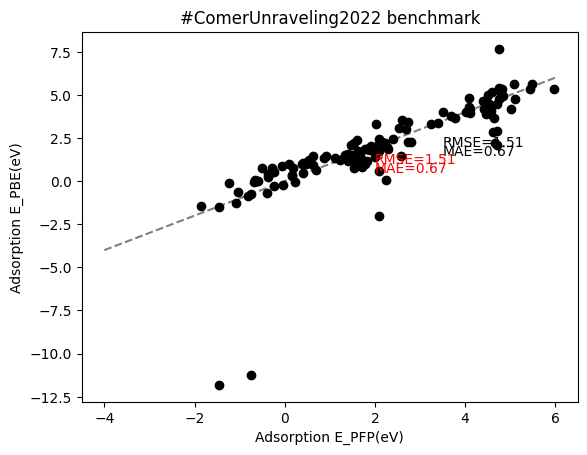

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def err_est(pfp_E):
    rms = mean_squared_error(real_E, pfp_E, squared=False)
    mae=mean_absolute_error(real_E, pfp_E)
    rms_str='RMSE='+str(round(rms,2))
    mae_str='MAE='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err
err2=err_est(m3gnet_test)
def plotall():
    plt.plot([-4,-1,0,1, 2, 3,6],[-4,-1,0,1, 2, 3,6],'--',color='black',alpha=0.5)
    plt.text(3.5,2,err2[0])
    plt.text(3.5,1.5,err2[1])
    plt.text(2,1,err2[0],color='red')
    plt.text(2,0.5,err2[1],color='red')
    #plt.scatter(real_out,pfp_out,color='black')
    plt.scatter(real_E,m3gnet_test,color='black')
    plt.title('#'+benchmark+' benchmark')
    plt.xlabel('Adsorption E_PFP(eV)')
    plt.ylabel('Adsorption E_PBE(eV)')
    plt.show()

plotall()